# Importing Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
import torch.utils as utils
import torch.utils.data as data
from PIL import Image
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# Function to check if Image is valid or not
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [3]:
# Defining Data Loaders 
batch_size=64
transforms_list = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

train_data = torchvision.datasets.ImageFolder(root='./data2/train/',transform=transforms_list)
test_data = torchvision.datasets.ImageFolder(root='./data2/test/',transform=transforms_list)

train_data_loader = data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_data_loader = data.DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [4]:
# Our CNN Model on our data
class CNNNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [6]:
# Train Model Function
def train(model, optimizer, loss_fn, train_loader, test_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(test_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Test Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [7]:
# Defining Model
cnnnet = CNNNet()
cnnnet.to(device)
optimizer = optim.Adam(cnnnet.parameters(), lr=0.001)

In [8]:
train(cnnnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,test_data_loader, epochs=10, device=device)

Epoch: 0, Training Loss: 0.74, Test Loss: 0.69, accuracy = 0.50
Epoch: 1, Training Loss: 0.69, Test Loss: 0.69, accuracy = 0.50
Epoch: 2, Training Loss: 0.69, Test Loss: 0.69, accuracy = 0.50
Epoch: 3, Training Loss: 0.69, Test Loss: 0.77, accuracy = 0.53
Epoch: 4, Training Loss: 0.70, Test Loss: 0.69, accuracy = 0.56
Epoch: 5, Training Loss: 0.69, Test Loss: 0.71, accuracy = 0.55
Epoch: 6, Training Loss: 0.65, Test Loss: 0.65, accuracy = 0.64
Epoch: 7, Training Loss: 0.62, Test Loss: 0.62, accuracy = 0.67
Epoch: 8, Training Loss: 0.60, Test Loss: 0.59, accuracy = 0.69
Epoch: 9, Training Loss: 0.56, Test Loss: 0.59, accuracy = 0.70


# Transfer Learning using ResNet50 Model

In [11]:
# Loading Pretrained ResNet Model
transfer_model = models.resnet50(pretrained=True)

In [12]:
# Freezing paramters
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [13]:
# Replacing Classifier head to predict just two classes i.e Cat or Dog
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500), \
    nn.ReLU(),        
    nn.Dropout(), 
    nn.Linear(500,2))

In [14]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [15]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,test_data_loader, epochs=10, device=device)

Epoch: 0, Training Loss: 0.44, Test Loss: 0.28, accuracy = 0.88
Epoch: 1, Training Loss: 0.24, Test Loss: 0.25, accuracy = 0.90
Epoch: 2, Training Loss: 0.16, Test Loss: 0.25, accuracy = 0.90
Epoch: 3, Training Loss: 0.12, Test Loss: 0.27, accuracy = 0.90
Epoch: 4, Training Loss: 0.12, Test Loss: 0.25, accuracy = 0.91
Epoch: 5, Training Loss: 0.09, Test Loss: 0.30, accuracy = 0.91
Epoch: 6, Training Loss: 0.06, Test Loss: 0.31, accuracy = 0.91
Epoch: 7, Training Loss: 0.06, Test Loss: 0.36, accuracy = 0.91
Epoch: 8, Training Loss: 0.09, Test Loss: 0.29, accuracy = 0.91
Epoch: 9, Training Loss: 0.06, Test Loss: 0.33, accuracy = 0.91


In [18]:
def get_prediction(filename,model):

    import requests
    from PIL import Image
    from io import BytesIO
    def download_image(url):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('myimage.jpeg')
    if 'http' in filename:
        download_image(filename)
        filename = './myimage.jpeg'
    
    labels = ['cat','dog']
    img = Image.open(filename) 
    img = transforms_list(img).to(device)
    img = img.unsqueeze(0) 
    import matplotlib.pyplot as plt
    def show_image(image_path):
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.show()
    show_image(filename)
    prediction = F.softmax(model(img))
    prediction = prediction.argmax()
    print("Prediction is : ", labels[prediction])

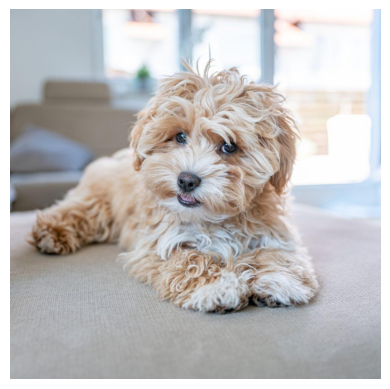

Prediction is :  cat


In [20]:
# Prediction from our CNN Model
get_prediction("https://hips.hearstapps.com/hmg-prod/images/small-fluffy-dog-breeds-maltipoo-66300ad363389.jpg?crop=0.668xw:1.00xh;0.151xw,0&resize=1200:*",cnnnet)

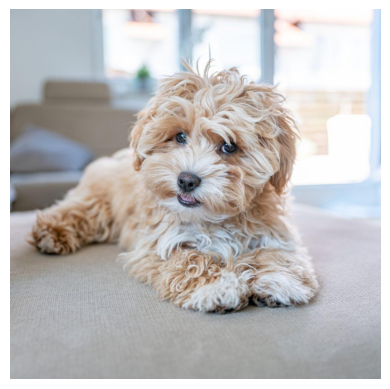

Prediction is :  dog


In [21]:
# Prediction from our Transfer Learning Model
get_prediction("https://hips.hearstapps.com/hmg-prod/images/small-fluffy-dog-breeds-maltipoo-66300ad363389.jpg?crop=0.668xw:1.00xh;0.151xw,0&resize=1200:*",transfer_model)